<h1><center>Eye Gaze Detection Using machine learning approach</center></h1>
<center>Lau Kin Fung, Mok Tse Chung</center>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from keras.models import load_model
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import keras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h1>Generate Image from csv file</h1>

Since the training.csv stores the RGB values of an image, we need to save all the image as jpg in order to visualize the image

In [4]:
def generate_image(csv_filepath, img_folderpath):
    df = read_csv(os.path.expanduser(csv_filepath))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    df = df.dropna()
    for index, row in df.iterrows():
        img_col = row['Image']
        img_col = img_col.reshape(96,96)
        img = Image.fromarray(img_col).convert('L')
        img.save(img_folderpath + '/' + str(index) + '.jpg')

<h1>Load the landmark detection dataset</h1>

This function is used to load the landmark detection dataset and return the image array X and label y.

In [5]:
def load_landmarks_data(csv_filepath, img_folderpath, isTest=False):
    X = []
    y = []
    df = read_csv(os.path.expanduser(csv_filepath))
    df = df.dropna()
    df = df.drop(columns=['Image'])
    img_files = os.listdir(img_folderpath)
    for file in img_files:
        if file != '.DS_Store':
            index = int(file.split('.jpg')[0])
            img = Image.open(img_folderpath + '/' + file).convert('L')
            img.load()
            img_arr = np.asarray(img, dtype="int32")
            img_arr = img_arr.reshape(96,96,1)
            X.append(img_arr)
            # if it is not getting the testing set, y is the ground truth
            if len(df.loc[[index]].values) > 0 and not isTest:
                labels_data = df.loc[[index]].values[0]
                labels_data = (labels_data - 48) / 48
                y.append(labels_data)
            # if it is getting the testing set, there is no ground truth
            else:
                y.append(None)
    X, y = shuffle(X, y, random_state=42)  # shuffle train data
    X = np.array(X) / 255
    y = np.array(y, dtype=np.float32)
    return X, y
    

In [6]:
# Load the landmark training data
X_train_landmarks, y_train_landmarks = load_landmarks_data('./dataset/training.csv', './dataset/face_keypoints_images/train')

<h1>CNN Model for landmark detection</h1>

In [7]:
# This is the CNN model for landmark detection
def CNN_Model_Landmark():
    model = keras.models.Sequential()

    model.add(keras.layers.Convolution2D(
        input_shape=(96, 96, 1),
        filters=16,
        kernel_size=(3,3),
        strides=1,
        padding='valid',
        activation='relu',
        data_format='channels_last'
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))

    model.add(keras.layers.Convolution2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu',
        strides=1,
        padding='valid',
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))
    
    model.add(keras.layers.Convolution2D(
        filters=64,
        kernel_size=(3,3),
        activation='relu',
        strides=1,
        padding='valid',
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))
    
    model.add(keras.layers.Convolution2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        strides=1,
        padding='valid',
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(
        units=512,
        activation='relu'
    ))
    
    model.add(keras.layers.Dropout(
        rate=0.2
    ))

    model.add(keras.layers.Dense(
        units=30,
    ))


    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.summary()
    
    return model


In [8]:
eye_landmarks_model = CNN_Model_Landmark()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

<h1>Train the CNN Model for landmark detection</h1>

Uncomment the following code if you want to retrain the model.

In [9]:
#train the landmark model
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

# hist is used to save the training history such as validation and training loss and accuracy
hist = History()

# check whether the current validation loss is minimal. If yes, save the weight
checkpointer = ModelCheckpoint(filepath='./trained_models_weights/landmark_weights.final.hdf5',
                              verbose=1, save_best_only=True)

# fit the landmark training data
hist_final = eye_landmarks_model.fit(X_train_landmarks, y_train_landmarks, validation_split=0.2,
          epochs=100, batch_size=64, verbose=1, callbacks=[checkpointer, hist])
          
# save the trained model
eye_landmarks_model.save('./trained_models_weights/landmark_model_final.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 85s 50ms/step - loss: 0.0258 - acc: 0.4959 - val_loss: 0.0094 - val_acc: 0.7126

Epoch 00001: val_loss improved from inf to 0.00941, saving model to ./trained_models_weights/landmark_weights.final.hdf5
Epoch 2/100
1712/1712 [==============================] - 72s 42ms/step - loss: 0.0089 - acc: 0.6192 - val_loss: 0.0052 - val_acc: 0.7126

Epoch 00002: val_loss improved from 0.00941 to 0.00519, saving model to ./trained_models_weights/landmark_weights.final.hdf5
Epoch 3/100
1712/1712 [==============================] - 73s 43ms/step - loss: 0.0067 - acc: 0.6221 - val_loss: 0.0046 - val_acc: 0.7126

Epoch 00003: val_loss improved from 0.00519 to 0.00459, saving model to ./trained_models_weights/landmark_weights.final.hdf5
Epoch 4/100
1712/1712 [==============================] - 71s 41ms/step - loss: 0.0059 - acc: 0.6554 - val_loss: 0.0045 - val_acc: 0.7103

Epoch 00004: val_loss improved

1712/1712 [==============================] - 37s 21ms/step - loss: 0.0014 - acc: 0.7874 - val_loss: 0.0015 - val_acc: 0.7850

Epoch 00035: val_loss did not improve
Epoch 36/100
1712/1712 [==============================] - 41s 24ms/step - loss: 0.0014 - acc: 0.7751 - val_loss: 0.0012 - val_acc: 0.7850

Epoch 00036: val_loss improved from 0.00129 to 0.00124, saving model to ./trained_models_weights/landmark_weights.final.hdf5
Epoch 37/100
1712/1712 [==============================] - 37s 21ms/step - loss: 0.0013 - acc: 0.7839 - val_loss: 0.0013 - val_acc: 0.7780

Epoch 00037: val_loss did not improve
Epoch 38/100
1712/1712 [==============================] - 37s 22ms/step - loss: 0.0013 - acc: 0.7739 - val_loss: 0.0013 - val_acc: 0.8061

Epoch 00038: val_loss did not improve
Epoch 39/100
1712/1712 [==============================] - 37s 22ms/step - loss: 0.0013 - acc: 0.7845 - val_loss: 0.0014 - val_acc: 0.8014

Epoch 00039: val_loss did not improve
Epoch 40/100
1712/1712 [=================

1712/1712 [==============================] - 37s 22ms/step - loss: 7.9307e-04 - acc: 0.8283 - val_loss: 0.0011 - val_acc: 0.7944

Epoch 00077: val_loss did not improve
Epoch 78/100
1712/1712 [==============================] - 37s 21ms/step - loss: 7.6117e-04 - acc: 0.8364 - val_loss: 0.0011 - val_acc: 0.8107

Epoch 00078: val_loss did not improve
Epoch 79/100
1712/1712 [==============================] - 38s 22ms/step - loss: 7.6061e-04 - acc: 0.8370 - val_loss: 0.0011 - val_acc: 0.7967

Epoch 00079: val_loss did not improve
Epoch 80/100
1712/1712 [==============================] - 37s 21ms/step - loss: 7.6937e-04 - acc: 0.8458 - val_loss: 0.0011 - val_acc: 0.7897

Epoch 00080: val_loss did not improve
Epoch 81/100
1712/1712 [==============================] - 37s 21ms/step - loss: 8.0814e-04 - acc: 0.8400 - val_loss: 0.0011 - val_acc: 0.8084

Epoch 00081: val_loss did not improve
Epoch 82/100
1712/1712 [==============================] - 42s 24ms/step - loss: 7.7479e-04 - acc: 0.8481 - v

In [10]:
# load the best weight to the model
eye_landmarks_model.load_weights('./trained_models_weights/landmark_weights.final.hdf5')

<h1>Accuracy and loss curves</h1>

Uncomment the following code if you retrained the CNN Model above.

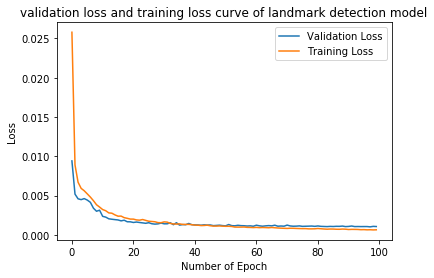

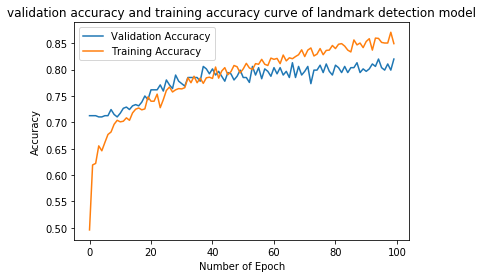

In [11]:
# Plot the validation loss and training loss curve of landmark detection model
plt.plot(range(100), hist_final.history['val_loss'], 'g-', label='Validation Loss', color='C0')
plt.plot(range(100), hist_final.history['loss'], 'g-', label='Training Loss', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('validation loss and training loss curve of landmark detection model')
plt.legend()
plt.show()

plt.plot(range(100), hist_final.history['val_acc'], 'g-', label='Validation Accuracy', color='C0')
plt.plot(range(100), hist_final.history['acc'], 'g-', label='Training Accuracy', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('validation accuracy and training accuracy curve of landmark detection model')
plt.legend()
plt.show()

In [12]:
# Load the landmark testing data
X_test, y_test = load_landmarks_data('./dataset/test.csv', './dataset/face_keypoints_images/test', True)

In [13]:
# Plot the landmarks on the image
def plot_data(img, landmarks, axis):
    axis.imshow(np.squeeze(img), cmap='gray')
    landmarks = landmarks*48+48
    axis.scatter(landmarks[0::2], landmarks[1::2], marker='o', c='c', s=10)

1783/1783 [==============================] - 15s 8ms/step


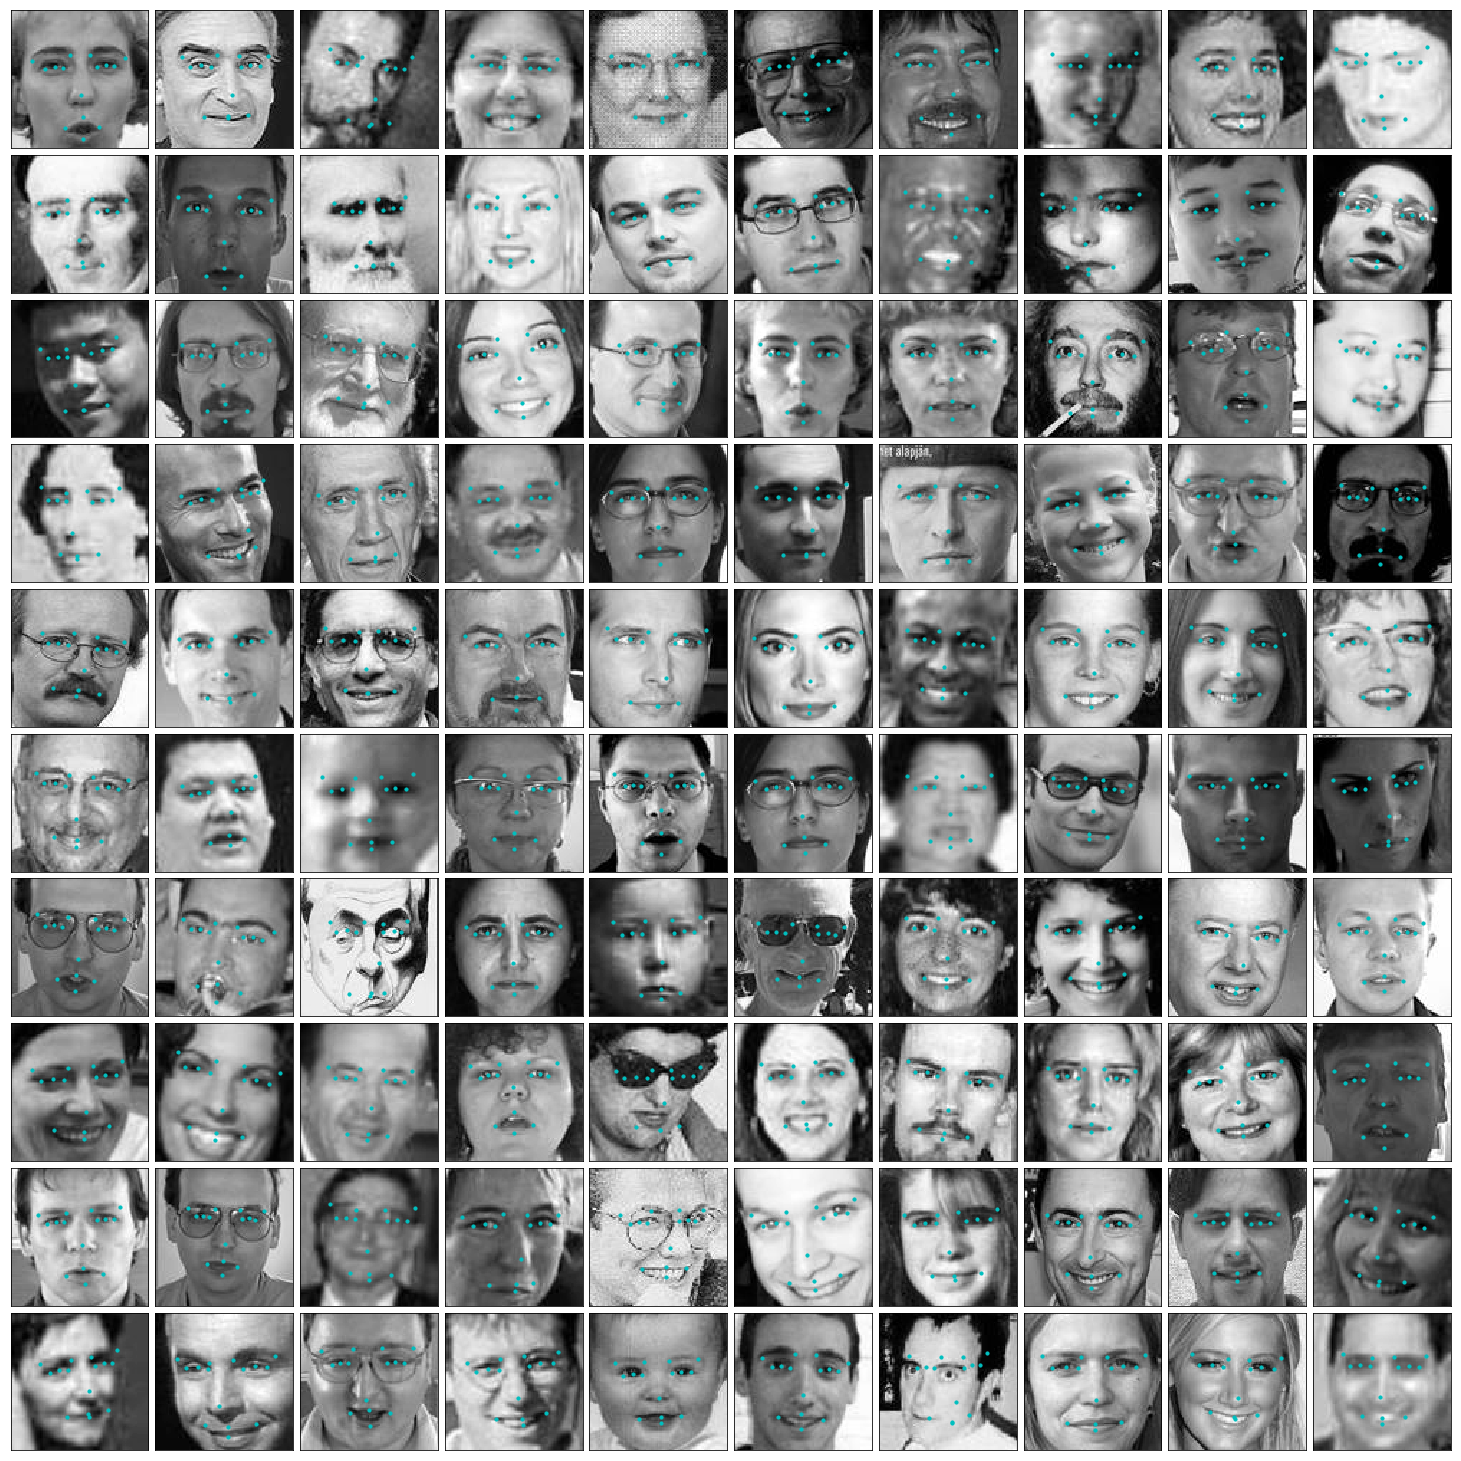

In [14]:
# Predict the landmarks of the testing set
y_predict = eye_landmarks_model.predict(X_test, verbose=1)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    plot_data(X_test[i], y_predict[i], ax)
    

<h1>CNN Model for eye gaze detection</h1>

We use the same CNN model structure to detect the left and right eyes eye gaze.

In [15]:
def CNN_Model_Eye_Gaze():
    model = keras.models.Sequential()

    model.add(keras.layers.Convolution2D(
        input_shape=(42, 50, 1),
        filters=24,
        kernel_size=(7,7),
        strides=1,
        padding='valid',
        activation='relu',
        data_format='channels_last'
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))

    model.add(keras.layers.Convolution2D(
        filters=24,
        kernel_size=(5,5),
        activation='relu',
        strides=1,
        padding='valid',
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))
    
    model.add(keras.layers.Convolution2D(
        filters=24,
        kernel_size=(3,3),
        activation='relu',
        strides=1,
        padding='valid',
    ))

    model.add(keras.layers.MaxPooling2D(
        pool_size=(2,2),
    ))
    
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(
        units=7,
        activation='softmax'
    ))

    sgd_optimizer = keras.optimizers.SGD(
        lr=0.1, decay=1e-6, nesterov=True, momentum=0.9)

    model.compile(optimizer=sgd_optimizer, loss='mse', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [16]:
# create a new cnn model for eye gaze detection of the left eye.
Left_Eye_Gaze_Model = CNN_Model_Eye_Gaze()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 36, 44, 24)        1200      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 22, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 18, 24)        14424     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 9, 24)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 7, 24)          5208      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 144)               0         
__________

In [17]:
# create a new cnn model for eye gaze detection of the right eye.
Right_Eye_Gaze_Model = CNN_Model_Eye_Gaze()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 36, 44, 24)        1200      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 22, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 18, 24)        14424     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 9, 24)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 7, 24)          5208      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 3, 24)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
__________

<h1>Face Extraction</h1>

We make use of OpenCV library to extract the face from an image.

In [18]:
def face_extraction(img_path):
    
    image = cv2.imread(img_path)
    
    # Convert the image to RGB colorspace
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)
    
    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)
    (x, y, w, h) = faces[0]
    
    gray = gray[y:y+h, x:x+w]
    gray = cv2.resize(gray, (96, 96)) / 255
    
    return gray, (x, y, w, h)

<h1>Eyes Extraction</h1>

This helps to extract the eye from the original image using the predicted landmarks, and the face coordinates in the original image

In [19]:
def get_eyes(prediction, folderpath, face_details):
    (x, y, w, h) = face_details
    left_eye_inner_corner_x = (prediction[4] * w / 96) + x
    left_eye_inner_corner_y = (prediction[5] * h / 96) + y
    left_eye_outer_corner_x = (prediction[6] * w / 96) + x
    left_eye_outer_corner_y = (prediction[7] * h / 96) + y
    right_eye_inner_corner_x = (prediction[8] * w / 96) + x
    right_eye_inner_corner_y = (prediction[9] * h / 96) + y
    right_eye_outer_corner_x = (prediction[10] * w / 96) + x
    right_eye_outer_corner_y = (prediction[11] * h / 96) + y
    left_eyebrow_inner_end_x = (prediction[12] * w / 96) + x
    left_eyebrow_inner_end_y = (prediction[13] * h / 96) + y
    left_eyebrow_outer_end_x = (prediction[14] * w / 96) + x
    left_eyebrow_outer_end_y = (prediction[15] * h / 96) + y
    right_eyebrow_inner_end_x = (prediction[16] * w / 96) + x
    right_eyebrow_inner_end_y = (prediction[17] * h / 96) + y
    right_eyebrow_outer_end_x = (prediction[18] * w / 96) + x
    right_eyebrow_outer_end_y = (prediction[19] * h / 96) + y
    height_diff_left_inner = abs(left_eyebrow_inner_end_y - left_eye_inner_corner_y)
    height_diff_left_outer = abs(left_eyebrow_outer_end_y - left_eye_outer_corner_y)
    height_left_eye = max(height_diff_left_inner, height_diff_left_outer) * 2
    height_diff_right_inner = abs(right_eyebrow_inner_end_y - right_eye_inner_corner_y)
    height_diff_right_outer = abs(right_eyebrow_outer_end_y - right_eye_outer_corner_y)
    height_right_eye = max(height_diff_right_inner, height_diff_right_outer) * 2
    if abs(left_eyebrow_outer_end_x - left_eyebrow_inner_end_x) > abs(left_eye_outer_corner_x - left_eye_inner_corner_x):
        width_left_eye = abs(left_eyebrow_outer_end_x - left_eyebrow_inner_end_x)
        left_eye_x = min(left_eyebrow_outer_end_x, left_eyebrow_inner_end_x)
    else:
        width_left_eye = abs(left_eye_outer_corner_x - left_eye_inner_corner_x)
        left_eye_x = min(left_eye_outer_corner_x, left_eye_inner_corner_x)
    if abs(right_eyebrow_outer_end_x - right_eyebrow_inner_end_x) > abs(right_eye_outer_corner_x - right_eye_inner_corner_x):
        width_right_eye = abs(right_eyebrow_outer_end_x - right_eyebrow_inner_end_x)
        right_eye_x = min(right_eyebrow_outer_end_x, right_eyebrow_inner_end_x)
    else:
        width_right_eye = abs(right_eye_outer_corner_x - right_eye_inner_corner_x)
        right_eye_x = min(right_eye_outer_corner_x, right_eye_inner_corner_x)
    
    img = Image.open(folderpath)
    left_eye_rect = (left_eye_x, left_eyebrow_outer_end_y, left_eye_x + width_left_eye, left_eyebrow_outer_end_y + height_left_eye)
    left_eye_img = img.crop(left_eye_rect).convert('L')
    left_eye_img = left_eye_img.resize((50,42), Image.ANTIALIAS)
    right_eye_rect = (right_eye_x, right_eyebrow_inner_end_y, right_eye_x + width_right_eye, right_eyebrow_inner_end_y + height_right_eye)
    right_eye_img = img.crop(right_eye_rect).convert('L')
    right_eye_img = right_eye_img.resize((50, 42), Image.ANTIALIAS)
    return left_eye_img, right_eye_img

<h1>Load eye gaze detection dataset</h1>

We extract the right and left eyes from the dataset and return X_left_eye, X_right_eye, y_left_eye, y_right_eye.

In [20]:
def load_eye_gaze_data(folderpath):
    X_left_eye = []
    X_right_eye = []
    y_left_eye = []
    y_right_eye = []
    dirs = os.listdir(folderpath)
    for img_dir in dirs:
        if img_dir != '.DS_Store':
            img_files = os.listdir(folderpath + '/' + img_dir)
            for img_file in img_files:
                if img_file != '.DS_Store':
                    try:
                        face_img, (x, y, w, h) = face_extraction(folderpath + '/' + img_dir + '/' + img_file)
                        landmarks_prediction = np.squeeze(eye_landmarks_model.predict(np.expand_dims(np.expand_dims(face_img, axis=-1), axis=0)))
                        landmarks_prediction = landmarks_prediction * 48 + 48

                        left_eye_img, right_eye_img = get_eyes(landmarks_prediction, folderpath + '/' + img_dir + '/' + img_file, (x, y, w, h)) 
                        left_eye_img.load()
                        img_arr_left = np.asarray(left_eye_img, dtype="int32")
                        img_arr_left = img_arr_left.reshape(42,50,1)
                        right_eye_img.load()
                        img_arr_right = np.asarray(right_eye_img, dtype="int32")
                        img_arr_right = img_arr_right.reshape(42,50,1)
                        if img_dir == 'Centre':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(0)
                            y_right_eye.append(0)
                        elif img_dir == 'DownLeft':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(1)
                            y_right_eye.append(1)
                        elif img_dir == 'DownRight':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(2)
                            y_right_eye.append(2)
                        elif img_dir == 'Left':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(3)
                            y_right_eye.append(3)
                        elif img_dir == 'Right':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(4)
                            y_right_eye.append(4)
                        elif img_dir == 'UpLeft':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(5)
                            y_right_eye.append(5)
                        elif img_dir == 'UpRight':
                            X_left_eye.append(img_arr_left)
                            X_right_eye.append(img_arr_right)
                            y_left_eye.append(6)
                            y_right_eye.append(6)
                    except:
                        continue

    X_left_eye = np.array(X_left_eye) / 255
    X_right_eye = np.array(X_right_eye) / 255
    y_left_eye = np.array(y_left_eye)
    y_right_eye = np.array(y_right_eye)
    X_left_eye, y_left_eye = shuffle(X_left_eye, y_left_eye, random_state=42)
    X_right_eye, y_right_eye = shuffle(X_right_eye, y_right_eye, random_state=42)
    return X_left_eye, X_right_eye, y_left_eye, y_right_eye

In [21]:
# load the eye gaze dataset (this may take a few minutes)
X_left_eye, X_right_eye, y_left_eye, y_right_eye = load_eye_gaze_data('./dataset/eye_gaze_images')

<h1>Splitting the eye gaze dataset</h1>

The following split the left and right eye dataset into training set and testing set randomly.
<br>
**NB. The random state for the left and right eye datasets is the same**

In [22]:
from sklearn.model_selection import train_test_split

X_left_eye_train, X_left_eye_test, y_left_eye_train, y_left_eye_test = train_test_split(X_left_eye, y_left_eye, test_size=0.20, random_state=42)
X_right_eye_train, X_right_eye_test, y_right_eye_train, y_right_eye_test = train_test_split(X_right_eye, y_right_eye, test_size=0.20, random_state=42)
y_left_eye_train_keras = keras.utils.to_categorical(y_left_eye_train)
y_left_eye_test_keras = keras.utils.to_categorical(y_left_eye_test)
y_right_eye_train_keras = keras.utils.to_categorical(y_right_eye_train)
y_right_eye_test_keras = keras.utils.to_categorical(y_right_eye_test)

<h1>Train the left eye CNN model for eye gaze detection</h1>

Uncomment the following code if you want to retrain the model.

In [23]:
from keras.callbacks import ModelCheckpoint, History

hist_left_eye_gaze = History()

checkpointer_left_eye_gaze = ModelCheckpoint(filepath='./trained_models_weights/weights_left_eye_gaze.final.hdf5',
                              verbose=1, save_best_only=True)
    
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

hist_left_eye = Left_Eye_Gaze_Model.fit_generator(datagen.flow(X_left_eye_train,y_left_eye_train_keras, batch_size=32),
                        steps_per_epoch=len(X_left_eye)/32, epochs=500, 
                        validation_data = [X_left_eye_test, y_left_eye_test_keras], 
                        callbacks=[checkpointer_left_eye_gaze, hist_left_eye_gaze])
          
Left_Eye_Gaze_Model.save('./trained_models_weights/my_model_final_left_eye_gaze.h5')

Epoch 1/500
36/35 [==============================] - 10s 266ms/step - loss: 0.1209 - acc: 0.2592 - val_loss: 0.1185 - val_acc: 0.3040

Epoch 00001: val_loss improved from inf to 0.11852, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 2/500
36/35 [==============================] - 9s 240ms/step - loss: 0.1193 - acc: 0.2740 - val_loss: 0.1171 - val_acc: 0.2996

Epoch 00002: val_loss improved from 0.11852 to 0.11711, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 3/500
36/35 [==============================] - 9s 241ms/step - loss: 0.1168 - acc: 0.2935 - val_loss: 0.1152 - val_acc: 0.3216

Epoch 00003: val_loss improved from 0.11711 to 0.11523, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 4/500
36/35 [==============================] - 8s 235ms/step - loss: 0.1153 - acc: 0.3019 - val_loss: 0.1115 - val_acc: 0.3524

Epoch 00004: val_loss improved from 0.11523 to 0.11151, saving model to ./tra

36/35 [==============================] - 8s 231ms/step - loss: 0.0646 - acc: 0.6663 - val_loss: 0.0512 - val_acc: 0.7357

Epoch 00035: val_loss did not improve
Epoch 36/500
36/35 [==============================] - 9s 236ms/step - loss: 0.0649 - acc: 0.6791 - val_loss: 0.0401 - val_acc: 0.7974

Epoch 00036: val_loss improved from 0.04357 to 0.04005, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 37/500
36/35 [==============================] - 8s 234ms/step - loss: 0.0631 - acc: 0.6700 - val_loss: 0.0450 - val_acc: 0.7797

Epoch 00037: val_loss did not improve
Epoch 38/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0625 - acc: 0.6960 - val_loss: 0.0466 - val_acc: 0.7621

Epoch 00038: val_loss did not improve
Epoch 39/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0630 - acc: 0.6816 - val_loss: 0.0507 - val_acc: 0.7401

Epoch 00039: val_loss did not improve
Epoch 40/500
36/35 [==============================] - 9s

36/35 [==============================] - 9s 237ms/step - loss: 0.0472 - acc: 0.7764 - val_loss: 0.0373 - val_acc: 0.8150

Epoch 00078: val_loss did not improve
Epoch 79/500
36/35 [==============================] - 9s 241ms/step - loss: 0.0440 - acc: 0.7825 - val_loss: 0.0410 - val_acc: 0.8062

Epoch 00079: val_loss did not improve
Epoch 80/500
36/35 [==============================] - 9s 241ms/step - loss: 0.0430 - acc: 0.7963 - val_loss: 0.0360 - val_acc: 0.8326

Epoch 00080: val_loss did not improve
Epoch 81/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0441 - acc: 0.7806 - val_loss: 0.0344 - val_acc: 0.8502

Epoch 00081: val_loss did not improve
Epoch 82/500
36/35 [==============================] - 9s 247ms/step - loss: 0.0429 - acc: 0.7951 - val_loss: 0.0336 - val_acc: 0.8414

Epoch 00082: val_loss improved from 0.03376 to 0.03360, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 83/500
36/35 [==============================] - 9s


Epoch 00122: val_loss improved from 0.02706 to 0.02700, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 123/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0352 - acc: 0.8341 - val_loss: 0.0304 - val_acc: 0.8590

Epoch 00123: val_loss did not improve
Epoch 124/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0434 - acc: 0.7768 - val_loss: 0.0301 - val_acc: 0.8634

Epoch 00124: val_loss did not improve
Epoch 125/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0359 - acc: 0.8262 - val_loss: 0.0326 - val_acc: 0.8414

Epoch 00125: val_loss did not improve
Epoch 126/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0348 - acc: 0.8299 - val_loss: 0.0263 - val_acc: 0.8722

Epoch 00126: val_loss improved from 0.02700 to 0.02627, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 127/500
36/35 [==============================] - 8s 233ms/step - loss: 0.03


Epoch 00167: val_loss did not improve
Epoch 168/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0329 - acc: 0.8433 - val_loss: 0.0265 - val_acc: 0.8502

Epoch 00168: val_loss did not improve
Epoch 169/500
36/35 [==============================] - 8s 232ms/step - loss: 0.0330 - acc: 0.8432 - val_loss: 0.0247 - val_acc: 0.8722

Epoch 00169: val_loss did not improve
Epoch 170/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0312 - acc: 0.8458 - val_loss: 0.0300 - val_acc: 0.8722

Epoch 00170: val_loss did not improve
Epoch 171/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0338 - acc: 0.8362 - val_loss: 0.0343 - val_acc: 0.8502

Epoch 00171: val_loss did not improve
Epoch 172/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0332 - acc: 0.8403 - val_loss: 0.0295 - val_acc: 0.8414

Epoch 00172: val_loss did not improve
Epoch 173/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0326 - acc: 

36/35 [==============================] - 9s 238ms/step - loss: 0.0284 - acc: 0.8550 - val_loss: 0.0308 - val_acc: 0.8502

Epoch 00214: val_loss did not improve
Epoch 215/500
36/35 [==============================] - 8s 229ms/step - loss: 0.0296 - acc: 0.8575 - val_loss: 0.0227 - val_acc: 0.8811

Epoch 00215: val_loss did not improve
Epoch 216/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0253 - acc: 0.8893 - val_loss: 0.0254 - val_acc: 0.8855

Epoch 00216: val_loss did not improve
Epoch 217/500
36/35 [==============================] - 9s 249ms/step - loss: 0.0253 - acc: 0.8823 - val_loss: 0.0260 - val_acc: 0.8722

Epoch 00217: val_loss did not improve
Epoch 218/500
36/35 [==============================] - 9s 243ms/step - loss: 0.0296 - acc: 0.8576 - val_loss: 0.0250 - val_acc: 0.8811

Epoch 00218: val_loss did not improve
Epoch 219/500
36/35 [==============================] - 9s 237ms/step - loss: 0.0276 - acc: 0.8693 - val_loss: 0.0285 - val_acc: 0.8678

Epoch 00

36/35 [==============================] - 9s 237ms/step - loss: 0.0309 - acc: 0.8632 - val_loss: 0.0306 - val_acc: 0.8678

Epoch 00261: val_loss did not improve
Epoch 262/500
36/35 [==============================] - 8s 234ms/step - loss: 0.0279 - acc: 0.8666 - val_loss: 0.0289 - val_acc: 0.8590

Epoch 00262: val_loss did not improve
Epoch 263/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0268 - acc: 0.8741 - val_loss: 0.0328 - val_acc: 0.8546

Epoch 00263: val_loss did not improve
Epoch 264/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0272 - acc: 0.8663 - val_loss: 0.0252 - val_acc: 0.8899

Epoch 00264: val_loss did not improve
Epoch 265/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0282 - acc: 0.8745 - val_loss: 0.0220 - val_acc: 0.8899

Epoch 00265: val_loss did not improve
Epoch 266/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0253 - acc: 0.8819 - val_loss: 0.0242 - val_acc: 0.8899

Epoch 00

36/35 [==============================] - 9s 246ms/step - loss: 0.0201 - acc: 0.9080 - val_loss: 0.0203 - val_acc: 0.9207

Epoch 00308: val_loss improved from 0.02134 to 0.02033, saving model to ./trained_models_weights/weights_left_eye_gaze.final.hdf5
Epoch 309/500
36/35 [==============================] - 9s 246ms/step - loss: 0.0223 - acc: 0.9001 - val_loss: 0.0278 - val_acc: 0.8722

Epoch 00309: val_loss did not improve
Epoch 310/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0231 - acc: 0.8906 - val_loss: 0.0271 - val_acc: 0.8811

Epoch 00310: val_loss did not improve
Epoch 311/500
36/35 [==============================] - 9s 243ms/step - loss: 0.0244 - acc: 0.8832 - val_loss: 0.0251 - val_acc: 0.8811

Epoch 00311: val_loss did not improve
Epoch 312/500
36/35 [==============================] - 9s 255ms/step - loss: 0.0226 - acc: 0.8919 - val_loss: 0.0363 - val_acc: 0.8326

Epoch 00312: val_loss did not improve
Epoch 313/500
36/35 [==============================]

36/35 [==============================] - 9s 243ms/step - loss: 0.0212 - acc: 0.8975 - val_loss: 0.0230 - val_acc: 0.9031

Epoch 00354: val_loss did not improve
Epoch 355/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0205 - acc: 0.9079 - val_loss: 0.0299 - val_acc: 0.8590

Epoch 00355: val_loss did not improve
Epoch 356/500
36/35 [==============================] - 9s 245ms/step - loss: 0.0238 - acc: 0.8854 - val_loss: 0.0291 - val_acc: 0.8502

Epoch 00356: val_loss did not improve
Epoch 357/500
36/35 [==============================] - 10s 266ms/step - loss: 0.0232 - acc: 0.8931 - val_loss: 0.0303 - val_acc: 0.8722

Epoch 00357: val_loss did not improve
Epoch 358/500
36/35 [==============================] - 9s 250ms/step - loss: 0.0220 - acc: 0.8976 - val_loss: 0.0276 - val_acc: 0.8722

Epoch 00358: val_loss did not improve
Epoch 359/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0257 - acc: 0.8745 - val_loss: 0.0279 - val_acc: 0.8855

Epoch 0

36/35 [==============================] - 8s 234ms/step - loss: 0.0215 - acc: 0.9001 - val_loss: 0.0296 - val_acc: 0.8634

Epoch 00401: val_loss did not improve
Epoch 402/500
36/35 [==============================] - 8s 236ms/step - loss: 0.0242 - acc: 0.8923 - val_loss: 0.0276 - val_acc: 0.8678

Epoch 00402: val_loss did not improve
Epoch 403/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0234 - acc: 0.8927 - val_loss: 0.0388 - val_acc: 0.8238

Epoch 00403: val_loss did not improve
Epoch 404/500
36/35 [==============================] - 8s 236ms/step - loss: 0.0238 - acc: 0.8901 - val_loss: 0.0323 - val_acc: 0.8678

Epoch 00404: val_loss did not improve
Epoch 405/500
36/35 [==============================] - 9s 250ms/step - loss: 0.0236 - acc: 0.8945 - val_loss: 0.0264 - val_acc: 0.8767

Epoch 00405: val_loss did not improve
Epoch 406/500
36/35 [==============================] - 9s 252ms/step - loss: 0.0246 - acc: 0.8854 - val_loss: 0.0291 - val_acc: 0.8811

Epoch 00

36/35 [==============================] - 9s 237ms/step - loss: 0.0241 - acc: 0.8936 - val_loss: 0.0226 - val_acc: 0.8987

Epoch 00448: val_loss did not improve
Epoch 449/500
36/35 [==============================] - 9s 243ms/step - loss: 0.0240 - acc: 0.8924 - val_loss: 0.0300 - val_acc: 0.8767

Epoch 00449: val_loss did not improve
Epoch 450/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0229 - acc: 0.9006 - val_loss: 0.0273 - val_acc: 0.8767

Epoch 00450: val_loss did not improve
Epoch 451/500
36/35 [==============================] - 8s 233ms/step - loss: 0.0272 - acc: 0.8740 - val_loss: 0.0204 - val_acc: 0.9163

Epoch 00451: val_loss did not improve
Epoch 452/500
36/35 [==============================] - 9s 247ms/step - loss: 0.0253 - acc: 0.8858 - val_loss: 0.0235 - val_acc: 0.8811

Epoch 00452: val_loss did not improve
Epoch 453/500
36/35 [==============================] - 8s 233ms/step - loss: 0.0245 - acc: 0.8888 - val_loss: 0.0299 - val_acc: 0.8767

Epoch 00

36/35 [==============================] - 9s 250ms/step - loss: 0.0199 - acc: 0.9115 - val_loss: 0.0248 - val_acc: 0.8943

Epoch 00495: val_loss did not improve
Epoch 496/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0228 - acc: 0.8954 - val_loss: 0.0300 - val_acc: 0.8767

Epoch 00496: val_loss did not improve
Epoch 497/500
36/35 [==============================] - 8s 233ms/step - loss: 0.0238 - acc: 0.8910 - val_loss: 0.0333 - val_acc: 0.8546

Epoch 00497: val_loss did not improve
Epoch 498/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0221 - acc: 0.9001 - val_loss: 0.0304 - val_acc: 0.8678

Epoch 00498: val_loss did not improve
Epoch 499/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0190 - acc: 0.9118 - val_loss: 0.0223 - val_acc: 0.9163

Epoch 00499: val_loss did not improve
Epoch 500/500
36/35 [==============================] - 9s 246ms/step - loss: 0.0274 - acc: 0.8802 - val_loss: 0.0373 - val_acc: 0.8546

Epoch 00

<h1>Accuracy and loss curves</h1>

Uncomment the following code if you retrained the CNN Model above.

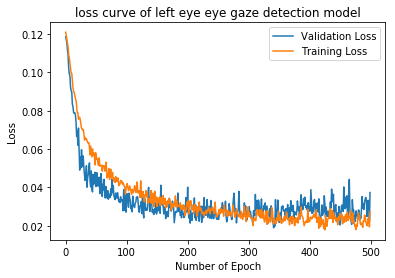

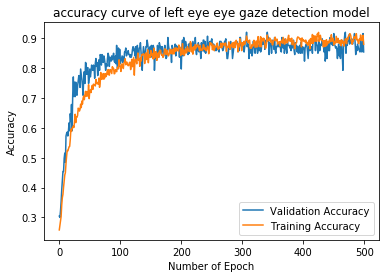

In [24]:
# Plot the validation loss and training loss curve of left eye eye gaze detection model
plt.plot(range(500), hist_left_eye_gaze.history['val_loss'], 'g-', label='Validation Loss', color='C0')
plt.plot(range(500), hist_left_eye_gaze.history['loss'], 'g-', label='Training Loss', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('loss curve of left eye eye gaze detection model')
plt.legend()
plt.show()

# Plot the validation accuracy and training accuracy curve of left eye eye gaze detection model
plt.plot(range(500), hist_left_eye_gaze.history['val_acc'], 'g-', label='Validation Accuracy', color='C0')
plt.plot(range(500), hist_left_eye_gaze.history['acc'], 'g-', label='Training Accuracy', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy curve of left eye eye gaze detection model')
plt.legend()
plt.show()

In [25]:
# load the best weight for the Left_Eye_Gaze_Model (pretrained)
Left_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_left_eye_gaze.final.hdf5')

In [26]:
# test the accuracy using testing set
y_left_eye_pred = Left_Eye_Gaze_Model.predict_classes(X_left_eye_test, 
                                     verbose=1)
left_eye_correct_preds = np.sum(y_left_eye_test == y_left_eye_pred, axis=0) 
left_eye_train_acc = left_eye_correct_preds / y_left_eye_test.shape[0]
print('Training accuracy: %.2f%%' % (left_eye_train_acc * 100))

227/227 [==============================] - 1s 4ms/step
Training accuracy: 92.07%


In [27]:
# This helps to plot the confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h1>Confusion matrix for the left eye CNN model</h1>

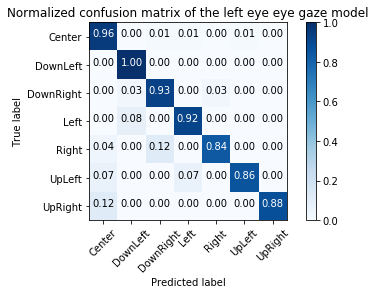

In [28]:
from sklearn.metrics import confusion_matrix

label_names = ['Center', 'DownLeft', 'DownRight', 'Left', 'Right', 'UpLeft', 'UpRight']
label_nums = [0, 1, 2, 3, 4, 5, 6]
left_eye_cm = confusion_matrix(y_left_eye_test, y_left_eye_pred)
plt.figure()
plot_confusion_matrix(left_eye_cm, classes=label_names, normalize=True,
                      title='Normalized confusion matrix of the left eye eye gaze model')

<h1>Train the right eye CNN model for eye gaze detection</h1>

Uncomment the following code if you want to retrain the model.

In [29]:
hist_right_eye_gaze = History()

checkpointer_right_eye_gaze = ModelCheckpoint(filepath='./trained_models_weights/weights_right_eye_gaze.final.hdf5',
                              verbose=1, save_best_only=True)
    
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Right_Eye_Gaze_Model.fit_generator(datagen.flow(X_right_eye_train, y_right_eye_train_keras, batch_size=32),
                        steps_per_epoch=len(X_right_eye)/32, epochs=500, 
                        validation_data = [X_right_eye_test, y_right_eye_test_keras], 
                        callbacks=[checkpointer_right_eye_gaze, hist_right_eye_gaze])

Right_Eye_Gaze_Model.save('./trained_models_weights/my_model_final_right_eye_gaze.h5')

Epoch 1/500
36/35 [==============================] - 10s 268ms/step - loss: 0.1213 - acc: 0.2514 - val_loss: 0.1191 - val_acc: 0.3040

Epoch 00001: val_loss improved from inf to 0.11909, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 2/500
36/35 [==============================] - 8s 234ms/step - loss: 0.1190 - acc: 0.2859 - val_loss: 0.1163 - val_acc: 0.3216

Epoch 00002: val_loss improved from 0.11909 to 0.11635, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 3/500
36/35 [==============================] - 9s 238ms/step - loss: 0.1166 - acc: 0.3283 - val_loss: 0.1124 - val_acc: 0.3568

Epoch 00003: val_loss improved from 0.11635 to 0.11242, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 4/500
36/35 [==============================] - 9s 238ms/step - loss: 0.1128 - acc: 0.3591 - val_loss: 0.1058 - val_acc: 0.3833

Epoch 00004: val_loss improved from 0.11242 to 0.10585, saving model to ./

36/35 [==============================] - 9s 240ms/step - loss: 0.0647 - acc: 0.6744 - val_loss: 0.0465 - val_acc: 0.8018

Epoch 00038: val_loss did not improve
Epoch 39/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0646 - acc: 0.6574 - val_loss: 0.0456 - val_acc: 0.7841

Epoch 00039: val_loss improved from 0.04611 to 0.04562, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 40/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0670 - acc: 0.6687 - val_loss: 0.0493 - val_acc: 0.7621

Epoch 00040: val_loss did not improve
Epoch 41/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0627 - acc: 0.6798 - val_loss: 0.0431 - val_acc: 0.7974

Epoch 00041: val_loss improved from 0.04562 to 0.04312, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 42/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0622 - acc: 0.6917 - val_loss: 0.0448 - val_acc: 0.7885



36/35 [==============================] - 8s 236ms/step - loss: 0.0455 - acc: 0.7720 - val_loss: 0.0463 - val_acc: 0.7709

Epoch 00082: val_loss did not improve
Epoch 83/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0508 - acc: 0.7482 - val_loss: 0.0434 - val_acc: 0.7974

Epoch 00083: val_loss did not improve
Epoch 84/500
36/35 [==============================] - 8s 234ms/step - loss: 0.0457 - acc: 0.7737 - val_loss: 0.0430 - val_acc: 0.8018

Epoch 00084: val_loss did not improve
Epoch 85/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0490 - acc: 0.7595 - val_loss: 0.0387 - val_acc: 0.8194

Epoch 00085: val_loss did not improve
Epoch 86/500
36/35 [==============================] - 8s 233ms/step - loss: 0.0455 - acc: 0.7750 - val_loss: 0.0401 - val_acc: 0.8150

Epoch 00086: val_loss did not improve
Epoch 87/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0465 - acc: 0.7725 - val_loss: 0.0477 - val_acc: 0.7753

Epoch 00087: 

36/35 [==============================] - 9s 237ms/step - loss: 0.0369 - acc: 0.8146 - val_loss: 0.0334 - val_acc: 0.8414

Epoch 00128: val_loss improved from 0.03346 to 0.03340, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 129/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0414 - acc: 0.7964 - val_loss: 0.0343 - val_acc: 0.8326

Epoch 00129: val_loss did not improve
Epoch 130/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0384 - acc: 0.8207 - val_loss: 0.0335 - val_acc: 0.8370

Epoch 00130: val_loss did not improve
Epoch 131/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0391 - acc: 0.8154 - val_loss: 0.0298 - val_acc: 0.8634

Epoch 00131: val_loss improved from 0.03340 to 0.02977, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 132/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0371 - acc: 0.8181 - val_loss: 0.0332 - val_acc: 0.85


Epoch 00173: val_loss did not improve
Epoch 174/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0327 - acc: 0.8454 - val_loss: 0.0303 - val_acc: 0.8502

Epoch 00174: val_loss did not improve
Epoch 175/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0342 - acc: 0.8320 - val_loss: 0.0317 - val_acc: 0.8546

Epoch 00175: val_loss did not improve
Epoch 176/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0324 - acc: 0.8463 - val_loss: 0.0279 - val_acc: 0.8811

Epoch 00176: val_loss improved from 0.02806 to 0.02787, saving model to ./trained_models_weights/weights_right_eye_gaze.final.hdf5
Epoch 177/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0312 - acc: 0.8514 - val_loss: 0.0318 - val_acc: 0.8414

Epoch 00177: val_loss did not improve
Epoch 178/500
36/35 [==============================] - 8s 236ms/step - loss: 0.0363 - acc: 0.8250 - val_loss: 0.0279 - val_acc: 0.8634

Epoch 00178: val_loss did not improv

36/35 [==============================] - 9s 237ms/step - loss: 0.0317 - acc: 0.8515 - val_loss: 0.0273 - val_acc: 0.8722

Epoch 00219: val_loss did not improve
Epoch 220/500
36/35 [==============================] - 8s 232ms/step - loss: 0.0292 - acc: 0.8622 - val_loss: 0.0353 - val_acc: 0.8282

Epoch 00220: val_loss did not improve
Epoch 221/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0322 - acc: 0.8519 - val_loss: 0.0319 - val_acc: 0.8458

Epoch 00221: val_loss did not improve
Epoch 222/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0349 - acc: 0.8368 - val_loss: 0.0284 - val_acc: 0.8678

Epoch 00222: val_loss did not improve
Epoch 223/500
36/35 [==============================] - 8s 231ms/step - loss: 0.0270 - acc: 0.8731 - val_loss: 0.0269 - val_acc: 0.8855

Epoch 00223: val_loss did not improve
Epoch 224/500
36/35 [==============================] - 9s 241ms/step - loss: 0.0319 - acc: 0.8454 - val_loss: 0.0368 - val_acc: 0.8414

Epoch 00

36/35 [==============================] - 9s 245ms/step - loss: 0.0311 - acc: 0.8472 - val_loss: 0.0327 - val_acc: 0.8502

Epoch 00266: val_loss did not improve
Epoch 267/500
36/35 [==============================] - 8s 233ms/step - loss: 0.0336 - acc: 0.8471 - val_loss: 0.0316 - val_acc: 0.8678

Epoch 00267: val_loss did not improve
Epoch 268/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0296 - acc: 0.8585 - val_loss: 0.0294 - val_acc: 0.8767

Epoch 00268: val_loss did not improve
Epoch 269/500
36/35 [==============================] - 9s 237ms/step - loss: 0.0304 - acc: 0.8493 - val_loss: 0.0266 - val_acc: 0.8855

Epoch 00269: val_loss did not improve
Epoch 270/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0294 - acc: 0.8576 - val_loss: 0.0291 - val_acc: 0.8634

Epoch 00270: val_loss did not improve
Epoch 271/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0365 - acc: 0.8232 - val_loss: 0.0256 - val_acc: 0.8811

Epoch 00


Epoch 00311: val_loss did not improve
Epoch 312/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0303 - acc: 0.8658 - val_loss: 0.0289 - val_acc: 0.8722

Epoch 00312: val_loss did not improve
Epoch 313/500
36/35 [==============================] - 9s 241ms/step - loss: 0.0288 - acc: 0.8602 - val_loss: 0.0315 - val_acc: 0.8546

Epoch 00313: val_loss did not improve
Epoch 314/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0272 - acc: 0.8893 - val_loss: 0.0299 - val_acc: 0.8722

Epoch 00314: val_loss did not improve
Epoch 315/500
36/35 [==============================] - 9s 239ms/step - loss: 0.0339 - acc: 0.8424 - val_loss: 0.0259 - val_acc: 0.8855

Epoch 00315: val_loss did not improve
Epoch 316/500
36/35 [==============================] - 9s 241ms/step - loss: 0.0323 - acc: 0.8442 - val_loss: 0.0296 - val_acc: 0.8634

Epoch 00316: val_loss did not improve
Epoch 317/500
36/35 [==============================] - 8s 234ms/step - loss: 0.0328 - acc: 

36/35 [==============================] - 9s 239ms/step - loss: 0.0287 - acc: 0.8632 - val_loss: 0.0277 - val_acc: 0.8634

Epoch 00359: val_loss did not improve
Epoch 360/500
36/35 [==============================] - 9s 237ms/step - loss: 0.0318 - acc: 0.8598 - val_loss: 0.0289 - val_acc: 0.8722

Epoch 00360: val_loss did not improve
Epoch 361/500
36/35 [==============================] - 9s 240ms/step - loss: 0.0278 - acc: 0.8741 - val_loss: 0.0352 - val_acc: 0.8238

Epoch 00361: val_loss did not improve
Epoch 362/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0258 - acc: 0.8823 - val_loss: 0.0244 - val_acc: 0.8899

Epoch 00362: val_loss did not improve
Epoch 363/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0283 - acc: 0.8649 - val_loss: 0.0315 - val_acc: 0.8634

Epoch 00363: val_loss did not improve
Epoch 364/500
36/35 [==============================] - 9s 261ms/step - loss: 0.0296 - acc: 0.8637 - val_loss: 0.0278 - val_acc: 0.8855

Epoch 00


Epoch 00405: val_loss did not improve
Epoch 406/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0255 - acc: 0.8815 - val_loss: 0.0268 - val_acc: 0.8678

Epoch 00406: val_loss did not improve
Epoch 407/500
36/35 [==============================] - 9s 244ms/step - loss: 0.0260 - acc: 0.8797 - val_loss: 0.0288 - val_acc: 0.8722

Epoch 00407: val_loss did not improve
Epoch 408/500
36/35 [==============================] - 9s 238ms/step - loss: 0.0247 - acc: 0.8849 - val_loss: 0.0255 - val_acc: 0.8855

Epoch 00408: val_loss did not improve
Epoch 409/500
36/35 [==============================] - 8s 235ms/step - loss: 0.0261 - acc: 0.8810 - val_loss: 0.0275 - val_acc: 0.8722

Epoch 00409: val_loss did not improve
Epoch 410/500
36/35 [==============================] - 8s 236ms/step - loss: 0.0289 - acc: 0.8697 - val_loss: 0.0288 - val_acc: 0.8678

Epoch 00410: val_loss did not improve
Epoch 411/500
36/35 [==============================] - 9s 243ms/step - loss: 0.0272 - acc: 

36/35 [==============================] - 9s 250ms/step - loss: 0.0279 - acc: 0.8745 - val_loss: 0.0264 - val_acc: 0.8855

Epoch 00453: val_loss did not improve
Epoch 454/500
36/35 [==============================] - 10s 290ms/step - loss: 0.0264 - acc: 0.8736 - val_loss: 0.0364 - val_acc: 0.8502

Epoch 00454: val_loss did not improve
Epoch 455/500
36/35 [==============================] - 9s 237ms/step - loss: 0.0345 - acc: 0.8376 - val_loss: 0.0368 - val_acc: 0.8370

Epoch 00455: val_loss did not improve
Epoch 456/500
36/35 [==============================] - 9s 237ms/step - loss: 0.0321 - acc: 0.8489 - val_loss: 0.0278 - val_acc: 0.8722

Epoch 00456: val_loss did not improve
Epoch 457/500
36/35 [==============================] - 9s 245ms/step - loss: 0.0316 - acc: 0.8506 - val_loss: 0.0254 - val_acc: 0.8722

Epoch 00457: val_loss did not improve
Epoch 458/500
36/35 [==============================] - 9s 242ms/step - loss: 0.0275 - acc: 0.8636 - val_loss: 0.0243 - val_acc: 0.8943

Epoch 0

36/35 [==============================] - 9s 250ms/step - loss: 0.0239 - acc: 0.8915 - val_loss: 0.0272 - val_acc: 0.8899

Epoch 00500: val_loss did not improve


<h1>Accuracy and loss curves</h1>

Uncomment the following code if you retrained the CNN Model above.

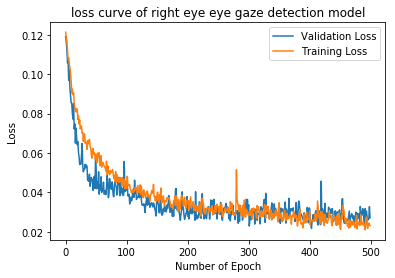

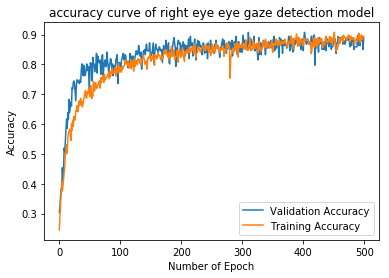

In [30]:
# Plot the validation loss and training loss curve of right eye eye gaze detection model
plt.plot(range(500), hist_right_eye_gaze.history['val_loss'], 'g-', label='Validation Loss', color='C0')
plt.plot(range(500), hist_right_eye_gaze.history['loss'], 'g-', label='Training Loss', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('loss curve of right eye eye gaze detection model')
plt.legend()
plt.show()

# Plot the validation accuracy and training accuracy curve of right eye eye gaze detection model
plt.plot(range(500), hist_right_eye_gaze.history['val_acc'], 'g-', label='Validation Accuracy', color='C0')
plt.plot(range(500), hist_right_eye_gaze.history['acc'], 'g-', label='Training Accuracy', color='C1')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy curve of right eye eye gaze detection model')
plt.legend()
plt.show()

In [31]:
# load the best weight for the Left_Eye_Gaze_Model (pretrained)
Right_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_right_eye_gaze.final.hdf5')

In [32]:
# test the accuracy using testing set
y_right_eye_pred = Right_Eye_Gaze_Model.predict_classes(X_right_eye_test, 
                                     verbose=1)
right_eye_correct_preds = np.sum(y_right_eye_test == y_right_eye_pred, axis=0) 
right_eye_train_acc = right_eye_correct_preds / y_right_eye_test.shape[0]
print('Training accuracy: %.2f%%' % (right_eye_train_acc * 100))

227/227 [==============================] - 1s 4ms/step
Training accuracy: 89.43%


<h1>Confusion matrix for the left eye CNN model</h1>

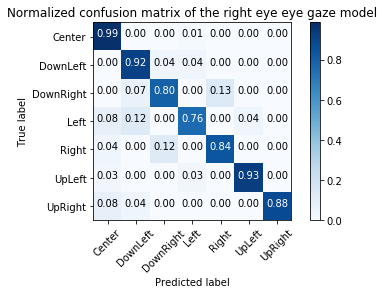

In [33]:
right_eye_cm = confusion_matrix(y_right_eye_test, y_right_eye_pred)
plt.figure()
plot_confusion_matrix(right_eye_cm, classes=label_names, normalize=True,
                      title='Normalized confusion matrix of the right eye eye gaze model')

<h1>Combining the result of left and right eye CNN model</h1>

The following adds the probability from the left and right eye CNN model and return the class having the largest probability.

In [34]:
import operator
def final_prediction(left_eye_prob, right_eye_prob):
    overall_prob = (left_eye_prob + right_eye_prob) / 2
    index, value = max(enumerate(overall_prob), key=operator.itemgetter(1))
    return index

In [35]:
# test the models 
y_left_eye_pred_prob = Left_Eye_Gaze_Model.predict(X_left_eye_test, 
                                     verbose=1)
y_right_eye_pred_prob = Right_Eye_Gaze_Model.predict(X_right_eye_test, 
                                     verbose=1)

y_two_eyes_pred = []
for i in range(len(y_left_eye_pred_prob)):
    pred = final_prediction(y_left_eye_pred_prob[i], y_right_eye_pred_prob[i])
    y_two_eyes_pred.append(pred)

227/227 [==============================] - 1s 5ms/step


In [36]:
two_eyes_correct_preds = np.sum(y_left_eye_test == y_two_eyes_pred, axis=0) 
two_eyes_train_acc = two_eyes_correct_preds / y_left_eye_test.shape[0]
print('Training accuracy: %.2f%%' % (two_eyes_train_acc * 100))

Training accuracy: 92.95%


<h1>Confusion matrix for final prediction</h1>

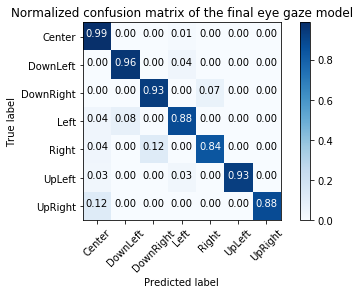

In [37]:
two_eyes_cm = confusion_matrix(y_left_eye_test, y_two_eyes_pred)
plt.figure()
plot_confusion_matrix(two_eyes_cm, classes=label_names, normalize=True,
                      title='Normalized confusion matrix of the final eye gaze model')

<h1>Precision and recall for the prediction </h1>

In [38]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_left_eye_test, y_two_eyes_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.91891892 0.92       0.90322581 0.88       0.91304348 1.
 1.        ]
recall: [0.98550725 0.95833333 0.93333333 0.88       0.84       0.93103448
 0.88      ]
fscore: [0.95104895 0.93877551 0.91803279 0.88       0.875      0.96428571
 0.93617021]
support: [69 24 30 25 25 29 25]


<h1>Eye gaze prediction function</h1>

arg: image path

In [39]:
from keras.models import load_model
def predict(image_path):
    eye_landmarks_model = CNN_Model_Landmark()
    Left_Eye_Gaze_Model = CNN_Model_Eye_Gaze()
    Right_Eye_Gaze_Model = CNN_Model_Eye_Gaze()
    
    # load the best weight to the model
    eye_landmarks_model.load_weights('./trained_models_weights/landmark_weights.final.hdf5')
    Left_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_left_eye_gaze.final.hdf5')
    Right_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_right_eye_gaze.final.hdf5')
    
    class_name = ['Center', 'Down Left', 'Down Right', 'Left', 'Right', 'Up Left', 'Up Right']
    face_img, (x, y, w, h) = face_extraction(image_path)
    landmarks_prediction = np.squeeze(eye_landmarks_model.predict(np.expand_dims(np.expand_dims(face_img, axis=-1), axis=0)))
    landmarks_prediction = landmarks_prediction * 48 + 48
    left_eye_img, right_eye_img = get_eyes(landmarks_prediction, image_path, (x, y, w, h)) 
    left_eye_img.load()
    img_arr_left = np.asarray(left_eye_img, dtype="int32")
    img_arr_left = img_arr_left.reshape(42,50,1)
    right_eye_img.load()
    img_arr_right = np.asarray(right_eye_img, dtype="int32")
    img_arr_right = img_arr_right.reshape(42,50,1)
    
    left_eye_prediction = Left_Eye_Gaze_Model.predict(img_arr_left.reshape(1, 42, 50, 1))[0]
    right_eye_prediction = Right_Eye_Gaze_Model.predict(img_arr_right.reshape(1, 42, 50, 1))[0]
    pred_class = final_prediction(left_eye_prediction, right_eye_prediction)
    return class_name[pred_class]

<h1>Eye disease prediction</h1>

In [40]:
from keras.models import load_model
def predict_eye_disease(image_path):
    eye_landmarks_model = CNN_Model_Landmark()
    Left_Eye_Gaze_Model = CNN_Model_Eye_Gaze()
    Right_Eye_Gaze_Model = CNN_Model_Eye_Gaze()
    
    # load the best weight to the model
    eye_landmarks_model.load_weights('./trained_models_weights/landmark_weights.final.hdf5')
    Left_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_left_eye_gaze.final.hdf5')
    Right_Eye_Gaze_Model.load_weights('./trained_models_weights/weights_right_eye_gaze.final.hdf5')
    
    class_name = ['Center', 'Down Left', 'Down Right', 'Left', 'Right', 'Up Left', 'Up Right']
    face_img, (x, y, w, h) = face_extraction(image_path)
    landmarks_prediction = np.squeeze(eye_landmarks_model.predict(np.expand_dims(np.expand_dims(face_img, axis=-1), axis=0)))
    landmarks_prediction = landmarks_prediction * 48 + 48
    left_eye_img, right_eye_img = get_eyes(landmarks_prediction, image_path, (x, y, w, h)) 
    left_eye_img.load()
    img_arr_left = np.asarray(left_eye_img, dtype="int32")
    img_arr_left = img_arr_left.reshape(42,50,1)
    right_eye_img.load()
    img_arr_right = np.asarray(right_eye_img, dtype="int32")
    img_arr_right = img_arr_right.reshape(42,50,1)
    
    left_eye_prediction = Left_Eye_Gaze_Model.predict_classes(img_arr_left.reshape(1, 42, 50, 1))[0]
    right_eye_prediction = Right_Eye_Gaze_Model.predict_classes(img_arr_right.reshape(1, 42, 50, 1))[0]
    
    if left_eye_prediction == 0 and right_eye_prediction == 0:
        return 'Normal'
    elif left_eye_prediction == 4:
        return 'Left esotropia'
    elif left_eye_prediction == 3:
        return 'Left exotropia'
    elif left_eye_prediction == 1 or left_eye_prediction == 2 or left_eye_prediction == 5 or left_eye_prediction == 6:
        return 'Left hypertropia'
    elif right_eye_prediction == 4:
        return 'Right esotropia'
    elif right_eye_prediction == 3:
        return 'Right exotropia'
    elif right_eye_prediction == 1 or right_eye_prediction == 2 or right_eye_prediction == 5 or right_eye_prediction == 6:
        return 'Right hypertropia'
